In [42]:
import numpy as np
import matplotlib.pyplot as plt

### Funciones de Paredes

In [43]:
def permutation():
    global order, N
    order = np.random.permutation(N)

def vecino(s, j):
    global L, empty
    if j == 0:  # izquierda
        if s % L == 0:
            return empty
        else:
            return s - 1
    elif j == 1:  # derecha
        if s % L == L - 1:
            return empty
        else:
            return s + 1
    elif j == 2:  # abajo
        if s // L == 0:
            return empty
        else:
            return s - L
    elif j == 3:  # arriba
        if s // L == L - 1:
            return empty
        else:
            return s + L

def boundaries():
    global N, nn
    for s in range(N):
        for j in range(4):
            nn[s, j] = vecino(s, j)

def findroot(r):
    global parent
    while parent[r] >= 0:
        r = parent[r]
    return r

In [44]:
def mergeroots(r1, r2):
    global spanclussize, parent, ns, touchesLeft, touchesRight, Ss, sum_s2_ns
    if r1 == r2:
        return r1
    elif -parent[r1] > -parent[r2]:
        ns[-parent[r1]] -= 1
        ns[-parent[r2]] -= 1
        sum_s2_ns -= parent[r1]**2
        sum_s2_ns -= parent[r2]**2
        parent[r1] += parent[r2]
        parent[r2] = r1
        ns[-parent[r1]] += 1
        sum_s2_ns += parent[r1]**2
        touchesLeft[r1] = touchesLeft[r1] or touchesLeft[r2]
        touchesRight[r1] = touchesRight[r1] or touchesRight[r2]
        if touchesLeft[r1] and touchesRight[r1]:
            spanclussize = -parent[r1]
        return r1
    else:
        ns[-parent[r1]] -= 1
        ns[-parent[r2]] -= 1
        sum_s2_ns -= parent[r1]**2 
        sum_s2_ns -= parent[r2]**2
        parent[r2] += parent[r1]
        parent[r1] = r2
        ns[-parent[r2]] += 1
        sum_s2_ns += parent[r2]**2
        touchesLeft[r2] = touchesLeft[r2] or touchesLeft[r1]
        touchesRight[r2] = touchesRight[r2] or touchesRight[r1]
        if touchesLeft[r2] and touchesRight[r2]:
            spanclussize = -parent[r2]
        return r2

In [45]:
def percolate():
    global spanclussize, order, parent, nn, ipc, ns, S, Ss, sum_s2_ns

    PSpan = []
    spanclussize = 0
    ns = np.zeros(N + 1, dtype=int)
    nspcpar = np.zeros(N + 1, dtype=int)  # Inicializar nspcpar aquí

    parent = empty * np.ones(N, dtype=int)

    S = []
    sum_s2_ns = 0  # Inicializar la suma acumulativa de s**2 * ns
    den = 0 

    for i in range(N):
        r1 = s1 = order[i]
        parent[s1] = -1
        ns[1] += 1
        sum_s2_ns += 1
        for j in range(4):
            s2 = nn[s1, j]
            if s2 != empty and parent[s2] != empty:
                r1 = mergeroots(r1, findroot(s2))
        
        PSpan.append(spanclussize / (i + 1))

        den = (i+1 - spanclussize)
        if den == 0:
            Ss = 0
        else:
            Ss = (sum_s2_ns - (spanclussize**2)) / den
        
        S.append(Ss)

        if i + 1 > spanclussize:
            S[i] = (sum_s2_ns - spanclussize**2) / (i + 1 - spanclussize)

        if i == ipc:
            nspcpar = np.copy(ns)

    return np.array(PSpan), nspcpar, S

### Problema 3

In [46]:
# Configuración inicial
global L, N, empty, parent, nn, order, spanclussize, touchesLeft, touchesRight, S

sizes = [16, 32, 64, 128, 256]
muestras = 100

sprom_dict = {}
Pspanprom_dict = {}
nspc_dic = {}
Sprom_L = {}
Smax = {}
P_infty = {}
pc = 0.59275

for L in sizes:
    N = L**2
    empty = -(N + 1)
    nn = np.zeros((N, 4), dtype=int)
    boundaries()

    ipc = int(N * pc) - 1
    s = np.arange(0, N + 1, 1, dtype=int)
    nspcprom = np.zeros(N)
    Sprom = np.zeros(N)
    sprom = np.zeros(N)
    Pspanprom = np.zeros(N)

    for _ in range(muestras):
        touchesLeft = [i % L == 0 for i in range(N)]
        touchesRight = [i % L == L - 1 for i in range(N)]
        parent = empty * np.ones(N, dtype=int)
        permutation()
        PSpan, nspc, S = percolate()
        nspc = nspc[1:]
        Pspanprom += PSpan
        nspcprom += nspc
        sprom += S
        sprom += nspc * np.arange(1, N + 1)

    if spanclussize == muestras:
        sprom_dict[L] = np.nan
    else:
        sprom_dict[L] = sprom / muestras

    Pspanprom /= muestras
    nspcprom /= muestras
    Sprom /= muestras

    Pspanprom_dict[L] = Pspanprom
    P_infty[L] = Pspanprom[ipc]
    nspc_dic[L] = nspcprom
    Sprom_L[L] = Sprom
    Smax[L] = Sprom.max()

AttributeError: 'numpy.ndarray' object has no attribute 'append'

### Gráficas

In [ ]:
# Configuración de estilo de las gráficas
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tahoma']
plt.rc('mathtext', fontset='stix')

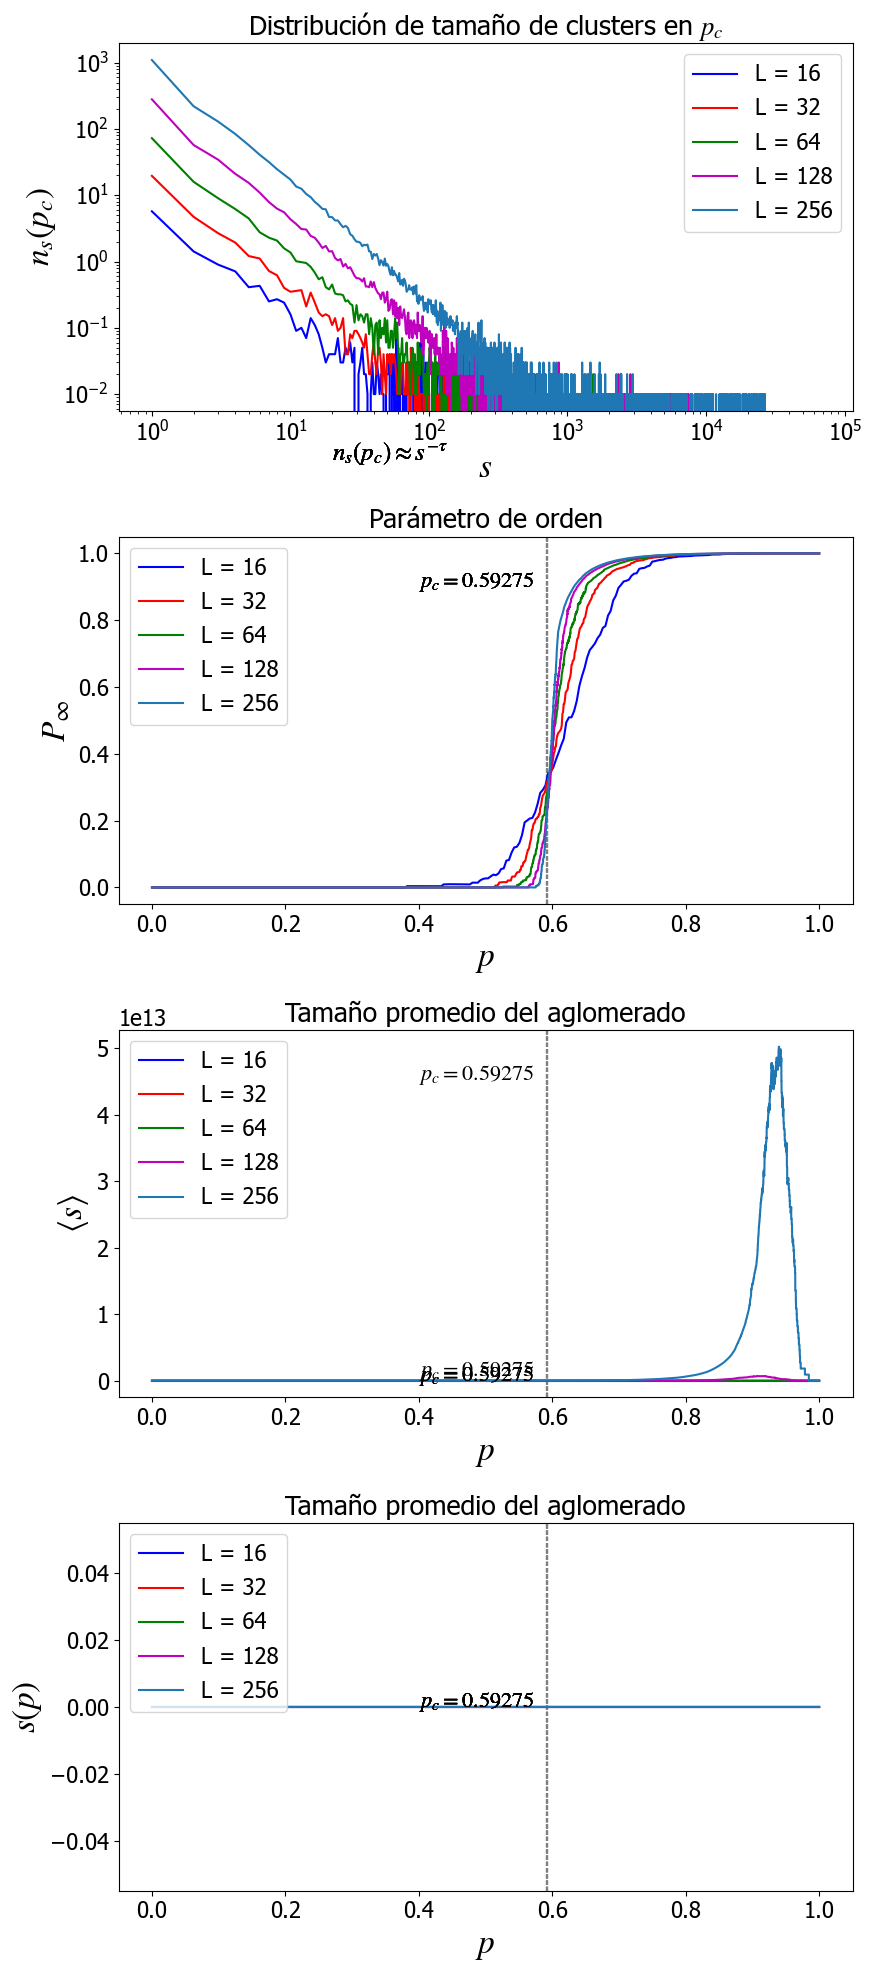

In [ ]:
# Gráficas

colors = ['b', 'r', 'g', 'm', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
fig, axs = plt.subplots(4, 1, figsize=(9, 20))  # Cambia a 4 subplots

for i, L in enumerate(sizes):
    N = L**2
    p = np.arange(1, N + 1) / N
    s = np.arange(1, N + 1)

    # Distribución de tamaño de clusters en p_c
    axs[0].loglog(s, nspc_dic[L], color=colors[i], label=f"L = {L}")
    axs[0].set_xlabel(r"$s$", fontsize=24)
    axs[0].set_ylabel(r"$n_s(p_c)$", fontsize=24)
    axs[0].set_title("Distribución de tamaño de clusters en $p_c$")
    axs[0].text(20, 0.001, r'$n_s(p_c) \approx s^{-\tau}$', fontsize=18)
    
    # Parámetro de orden
    axs[1].plot(p, Pspanprom_dict[L], color=colors[i], label=f"L = {L}")
    axs[1].set_xlabel(r"$p$", fontsize=24)
    axs[1].set_ylabel(r"$P_\infty$", fontsize=24)
    axs[1].set_title("Parámetro de orden")
    axs[1].axvline(pc, color="gray", dashes=(2, 1), zorder=-1)
    axs[1].text(0.4, 0.9, r'$p_c = 0.59275$')
    
    # Tamaño promedio del aglomerado
    axs[2].plot(p, sprom_dict[L], color=colors[i], label=f"L = {L}")
    axs[2].set_xlabel(r"$p$", fontsize=24)
    axs[2].set_ylabel(r"$\langle s \rangle$", fontsize=24)
    axs[2].set_title("Tamaño promedio del aglomerado")
    axs[2].axvline(pc, color="gray", dashes=(2, 1), zorder=-1)
    axs[2].text(0.4, 0.9 * max(sprom_dict[L]), r'$p_c = 0.59275$')

    # Tamaño promedio del aglomerado usando Sprom_L[L]
    axs[3].plot(p, Sprom_L[L], color=colors[i], label=f"L = {L}")
    axs[3].set_xlabel(r"$p$", fontsize=24)
    axs[3].set_ylabel(r"$s(p)$", fontsize=24)
    axs[3].set_title("Tamaño promedio del aglomerado")
    axs[3].axvline(pc, color="gray", dashes=(2, 1), zorder=-1)
    axs[3].text(0.4, 0.9 * max(Sprom_L[L]), r'$p_c = 0.59275$')

# Ajustar y mostrar las leyendas
for ax in axs:
    ax.legend()

# Ajustar el layout y mostrar la figura
fig.tight_layout()
plt.show()

## 4

In [ ]:
def lineFit(x, y):
    ''' Returns slope and y-intercept of linear fit to (x,y)
    data set'''
    xavg = x.mean()
    slope = (y * (x - xavg)).sum() / (x * (x - xavg)).sum()
    yint = y.mean() - slope * xavg
    return slope, yint

In [ ]:
loglados = np.log(lados**0.5)
logSmax = np.log(Smax)
fig = plt.figure(figsize = (14,14))

ax5 = fig.add_subplot(2,2,2)
slope, corte = lineFit(logSmax,loglados)
ajuste = slope*logSmax + corte
ax5.loglog(Smax,lados**0.5,'b',label = r'data')
ax5.loglog(Smax,np.exp(ajuste),color = 'red',dashes = (3,1),label = "ajuste")
ax5.legend(loc = 'best',fontsize = 12)
ax5.set_xlabel("log Smax",fontsize = 18)
ax5.set_ylabel("log lados",fontsize = 18)
print("gamma/nu= ",slope)
print("log(A)= ",corte)